<a href="https://colab.research.google.com/github/paresh-nayyar/CSCI-544_NLP/blob/master/Attenstion_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
import keras
from keras import optimizers, Model
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, SpatialDropout1D, LSTM, Bidirectional, TimeDistributed, Input
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 

In [4]:
import tensorflow as tf
from tensorflow.python.keras.layers import Layer

from keras import backend as K
from keras import initializers, regularizers, constraints

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8502569508645267167
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1745276110
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5825553937026527824
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

### Sample Data

In [7]:
url = "https://raw.githubusercontent.com/paresh-nayyar/CSCI-544_NLP/master/data/Towards_Emotion_Recognition_text%26emotions.csv?token=GHSAT0AAAAAABTGDUW44T65K3FPEHXLZEH6YS2IYSA"
df = pd.read_csv(url)
df.head()

tweet_id                                              tweet  anger  \
0      46149  don ko11mulko ki police sms kar rahi hai par d...      0   
1   40317002  khushi ki talaash me sabhi haiyn kya maiyn aur...      0   
2   40319032  are dostoin aao aur apne thoughts share karo l...      0   
3  308624342  na tum aa sako gay na phir baat hogi yeh kaisi...      0   
4  596311632  meethe gud me mil gaye til udi patang aur khil...      0   

   disgust  fear  happiness  sadness  surprise  
0        0     0          1        0         0  
1        0     0          0        1         0  
2        0     0          0        1         0  
3        0     0          0        1         0  
4        0     0          1        0         0

### Train and Test Dataset

In [8]:
df_train = pd.read_csv("https://raw.githubusercontent.com/paresh-nayyar/CSCI-544_NLP/master/data/TER_text%26emotions_train.csv?token=GHSAT0AAAAAABTGDUW4Z4NSREPWMSLDTSI2YS2IZMQ")
df_test = pd.read_csv("https://raw.githubusercontent.com/paresh-nayyar/CSCI-544_NLP/master/data/TER_text%26emotions_test.csv?token=GHSAT0AAAAAABTGDUW5CPXEKYEWNTBGPSDUYS2IY6Q")

In [9]:
df_train.head()

tweet_id                                              tweet  \
0   372412154051170304                           bsppsb kya scary cha hai   
1  1066362251538558976  urstrulymahesh thumsupofficial such an amazing...   
2    15364902520627200  mujhe in pathron ka darr na hota agr dil me sh...   
3   441535551506624512        mukhang ewan gross huehue httptcoet2dwibe6h   
4   593300371050668034  hathwalathakur chup kar be bhosdike teri green...   

   anger  disgust  fear  happiness  sadness  surprise  \
0      0        0     1          0        0         0   
1      0        0     0          0        0         1   
2      0        0     1          0        0         0   
3      0        1     0          0        0         0   
4      1        0     0          0        0         0   

                                       cleaned_tweet  \
0                           bsppsb kya scary cha hai   
1  urstrulymahesh thumsupofficial such an amazing...   
2  mujhe in pathron ka darr na hota agr dil me sh...   
3        mukhang ewan gross huehue httptcoet2dwibe6h   
4  hathwalathakur chup kar be bhosdike teri green...   

                                cleaned_tweet_tokens  
0           ['bsppsb', 'kya', 'scary', 'cha', 'hai']  
1  ['urstrulymahesh', 'thumsupofficial', 'such', ...  
2  ['mujhe', 'in', 'pathron', 'ka', 'darr', 'na',...  
3  ['mukhang', 'ewan', 'gross', 'huehue', 'httptc...  
4  ['hathwalathakur', 'chup', 'kar', 'be', 'bhosd...

In [10]:
df_train.shape

(107754, 10)

In [11]:
df_train.dtypes

tweet_id                 int64
tweet                   object
anger                    int64
disgust                  int64
fear                     int64
happiness                int64
sadness                  int64
surprise                 int64
cleaned_tweet           object
cleaned_tweet_tokens    object
dtype: object

In [12]:
df_train.isnull().sum()

tweet_id                0
tweet                   0
anger                   0
disgust                 0
fear                    0
happiness               0
sadness                 0
surprise                0
cleaned_tweet           0
cleaned_tweet_tokens    0
dtype: int64

In [13]:
df_test.head(5)

tweet_id                                              tweet  \
0   396552381644554241  dedhishqiya begumpara madhuridixit aye haye mu...   
1  1239596616287428608  chinvij morning sa sidherts ka disgusting twee...   
2   505791717014904832                murtaza ali shah chutiya and chawal   
3   504827097143971840  usay to kho dia hai ab na jane kis ko khona ha...   
4   271145832621957121                          haish haish kiseob woohoo   

   anger  disgust  fear  happiness  sadness  surprise  \
0      0        1     0          0        0         0   
1      0        1     0          0        0         0   
2      1        0     0          0        0         0   
3      0        0     0          0        1         0   
4      0        0     0          1        0         0   

                                       cleaned_tweet  \
0  dedhishqiya begumpara madhuridixit aye haye mu...   
1  chinvij morning sa sidherts ka disgusting twee...   
2                murtaza ali shah chutiya and chawal   
3  usay to kho dia hai ab na jane kis ko khona ha...   
4                          haish haish kiseob woohoo   

                                cleaned_tweet_tokens  
0  ['dedhishqiya', 'begumpara', 'madhuridixit', '...  
1  ['chinvij', 'morning', 'sa', 'sidherts', 'ka',...  
2  ['murtaza', 'ali', 'shah', 'chutiya', 'and', '...  
3  ['usay', 'to', 'kho', 'dia', 'hai', 'ab', 'na'...  
4             ['haish', 'haish', 'kiseob', 'woohoo']

In [14]:
set_a = set(df_train.tweet_id)
set_b = set(df_test.tweet_id)

In [15]:
df_test.shape

(26939, 10)

In [16]:
df_test.dtypes

tweet_id                 int64
tweet                   object
anger                    int64
disgust                  int64
fear                     int64
happiness                int64
sadness                  int64
surprise                 int64
cleaned_tweet           object
cleaned_tweet_tokens    object
dtype: object

In [17]:
df_test.isnull().sum()

tweet_id                0
tweet                   0
anger                   0
disgust                 0
fear                    0
happiness               0
sadness                 0
surprise                0
cleaned_tweet           0
cleaned_tweet_tokens    0
dtype: int64

### Class Distribution

In [18]:
def get_class_label(row):
    if row['anger'] == 1:
        return 'anger'
    if row['disgust'] == 1:
        return 'disgust'
    if row['fear'] == 1:
        return 'fear'
    if row['happiness'] == 1:
        return 'happiness'
    if row['sadness'] == 1:
        return 'sadness'
    if row['surprise'] == 1:
        return 'surprise'

In [19]:
df_train['class_label'] = df_train.apply (lambda row: get_class_label(row), axis=1)

In [20]:
df_test['class_label'] = df_test.apply (lambda row: get_class_label(row), axis=1)

In [21]:
df_train.columns

Index(['tweet_id', 'tweet', 'anger', 'disgust', 'fear', 'happiness', 'sadness',
       'surprise', 'cleaned_tweet', 'cleaned_tweet_tokens', 'class_label'],
      dtype='object')

In [22]:
df_train.loc[:, ['tweet', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'class_label']].sample(10)

tweet  anger  disgust  \
57922                        mandeep ne surprise kar diya      0        0   
24131   saath chhorny walon ko to ek bahana hi kafi ho...      0        0   
41501   saurabhraajjain madhav iss rakhi sirf ek hi wi...      0        0   
98342   hansi aati ha mujhe hasrateinsaan per gunnah k...      0        1   
79930   aishashabbir hopeisnotout aye haye pushto rust...      0        1   
95822   sidranadeem07 aye haye haye haye burjulkhalifa...      0        1   
44538   main khush hoon k uski nafraton ka akela waris...      0        0   
105174  bhagwaattankwa1 tu apne bahan se puchh bhosdik...      1        0   
10215   zindagi main log dukh ke siwa de bhi kya sakte...      0        0   
64392   wolfgen222 sootradhar officialdgispr bhosdike ...      1        0   

        fear  happiness  sadness  surprise class_label  
57922      0          0        0         1    surprise  
24131      0          0        0         1    surprise  
41501      0          1        0         0   happiness  
98342      0          0        0         0     disgust  
79930      0          0        0         0     disgust  
95822      0          0        0         0     disgust  
44538      0          1        0         0   happiness  
105174     0          0        0         0       anger  
10215      0          0        1         0     sadness  
64392      0          0        0         0       anger

In [23]:
classes = df_train.class_label.value_counts().index.tolist()
class_count = list(df_train.class_label.value_counts())

In [24]:
fig = go.Figure(data = [go.Bar(x=classes, y=class_count)])
fig.update_layout(title_text='Train Data Distribution',
                 yaxis=dict(title_text="Class-Count"),
                 xaxis=dict(title_text="Class"))
fig.show()

In [25]:
df_test.loc[:, ['tweet', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'class_label']].sample(10)

tweet  anger  disgust  \
21986  mein rooz pilati hon usay zeher ka piyala   ei...      0        0   
22946                auraalarm 1011b httpbitlyd1fewc wow      0        0   
19870  urstrulygadde gopalagopala amp i in bhimavaram...      0        1   
20364  teekhichilli to ek kam karo uske dosto ko bula...      0        0   
26139  amsad electionsmv bahlavaa presidencymv yuck m...      0        1   
7110   tejinderbagga sahi main chutiya nahi ghatiya a...      1        0   
14271  musfiqurrehman sala chutiya pagal hai kya bkch...      1        0   
13224  omg mere 14 followers hain mujhe to pata hi na...      0        0   
1094   nijam cheppaka povatam abaddam  abaddam nu nij...      0        0   
4792                           sanjaymanjrekar chutiya 😊      1        0   

       fear  happiness  sadness  surprise class_label  
21986     0          0        1         0     sadness  
22946     0          0        0         1    surprise  
19870     0          0        0         0     disgust  
20364     0          0        0         1    surprise  
26139     0          0        0         0     disgust  
7110      0          0        0         0       anger  
14271     0          0        0         0       anger  
13224     0          0        0         1    surprise  
1094      0          0        0         1    surprise  
4792      0          0        0         0       anger

In [26]:
classes = df_test.class_label.value_counts().index.tolist()
class_count = list(df_test.class_label.value_counts())

In [27]:
fig = go.Figure(data = [go.Bar(x=classes, y=class_count)])
fig.update_layout(title_text='Train Data Distribution',
                 yaxis=dict(title_text="Class-Count"),
                 xaxis=dict(title_text="Class"))
fig.show()

### Load Embeddings

In [28]:
from gensim.models import FastText
fasttext_url = "./fasttext_model/fasttext_model.model"
embeddings_index = FastText.load(fasttext_url)

In [29]:
embeddings_index.wv.most_similar(positive=['amazing'], topn = 10)

[('xyamazing', 0.9985262751579285),
 ('kjamazing', 0.9984499216079712),
 ('imsoamazing', 0.9981671571731567),
 ('😍👌amazing', 0.9981645345687866),
 ('a7amazing', 0.998141884803772),
 ('👌amazing', 0.9980849623680115),
 ('😯😍amazing', 0.9980295300483704),
 ('od13amazing', 0.9980289936065674),
 ('😘amazing', 0.9980139136314392),
 ('😍amazing', 0.9980130195617676)]

### Tokennization

In [30]:
df_train.head(2)

tweet_id                                              tweet  \
0   372412154051170304                           bsppsb kya scary cha hai   
1  1066362251538558976  urstrulymahesh thumsupofficial such an amazing...   

   anger  disgust  fear  happiness  sadness  surprise  \
0      0        0     1          0        0         0   
1      0        0     0          0        0         1   

                                       cleaned_tweet  \
0                           bsppsb kya scary cha hai   
1  urstrulymahesh thumsupofficial such an amazing...   

                                cleaned_tweet_tokens class_label  
0           ['bsppsb', 'kya', 'scary', 'cha', 'hai']        fear  
1  ['urstrulymahesh', 'thumsupofficial', 'such', ...    surprise

In [31]:
df_test.head(2)

tweet_id                                              tweet  \
0   396552381644554241  dedhishqiya begumpara madhuridixit aye haye mu...   
1  1239596616287428608  chinvij morning sa sidherts ka disgusting twee...   

   anger  disgust  fear  happiness  sadness  surprise  \
0      0        1     0          0        0         0   
1      0        1     0          0        0         0   

                                       cleaned_tweet  \
0  dedhishqiya begumpara madhuridixit aye haye mu...   
1  chinvij morning sa sidherts ka disgusting twee...   

                                cleaned_tweet_tokens class_label  
0  ['dedhishqiya', 'begumpara', 'madhuridixit', '...     disgust  
1  ['chinvij', 'morning', 'sa', 'sidherts', 'ka',...     disgust

In [32]:
processed_docs_train = df_train['tweet'].astype(str).tolist()
processed_docs_test = df_test['tweet'].astype(str).tolist() 

In [33]:
print(df_train.shape)
print(df_test.shape)

(107754, 11)
(26939, 11)


In [34]:
print(len(processed_docs_train))
print(len(processed_docs_test))

107754
26939


In [35]:
processed_docs_train[0:5]

['bsppsb kya scary cha hai',
 'urstrulymahesh thumsupofficial such an amazing ad urstrulymahesh bhayya',
 'mujhe in pathron ka darr na hota agr dil me sheeshe ka ghar na hota yaqenan hum bi kheltepyarki bazi agr dil k tootne ka darr na hota',
 'mukhang ewan gross huehue httptcoet2dwibe6h',
 'hathwalathakur chup kar be bhosdike teri green underwear se tu pakistani agent ban jayega ']

In [36]:
processed_docs_test[0:5]

['dedhishqiya begumpara madhuridixit aye haye mujhe mardala❤❤apsara is dancing❤ cant wait to see her shahi magic❤❤ httptcoe8blr4lwr1',
 'chinvij morning sa sidherts ka disgusting tweets dekh kar dill dukha hoa tha un logo ko ya bhi parwa nhi mv sid ka bhi ha wo dislike krne k plan kar rahe han but ap ki tweet dekh kar bohat acha laga 2 times name chk kia waqai sidhert ha hame mil kar change hona ha or positivity lane ha',
 'murtaza ali shah chutiya and chawal',
 'usay to kho dia hai ab na jane kis ko khona hai    lakeeron main judai ki alaamat ab b baqi hai sad urdu poetry',
 'haish haish kiseob woohoo']

In [37]:
MAX_NB_WORDS = 200000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)

total_docs=[]
total_docs.extend(processed_docs_train)
total_docs.extend(processed_docs_test)

tokenizer.fit_on_texts(total_docs)

word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)

word_index = tokenizer.word_index

In [38]:
print("dictionary size: ", len(word_index))

dictionary size:  235929


In [39]:
# get back the text
# text = tokenizer.sequences_to_texts(word_seq_train)

In [40]:
df_train['doc_len'] = df_train['tweet'].astype(str).apply(lambda words: len(words.split(" ")))

In [41]:
max_seq_len = np.round(df_train['doc_len'].mean() + df_train['doc_len'].std()).astype(int)
max_seq_len

28

In [42]:
# pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

In [43]:
print(len(processed_docs_train))
print(word_seq_train.shape)

107754
(107754, 28)


In [44]:
word_seq_train

array([[    0,     0,     0, ...,   108,  1424,     1],
       [    0,     0,     0, ...,  1793,  9451,  6759],
       [   59,    92, 10454, ...,    26,    13,    56],
       ...,
       [    0,     0,     0, ...,   678,   382, 42705],
       [    0,     0,     0, ...,   118,    13, 32625],
       [    0,     0,     0, ...,   779,    74, 23151]])

In [45]:
print(len(processed_docs_test))
print(word_seq_test.shape)

26939
(26939, 28)


In [46]:
word_seq_test

array([[   0,    0,    0, ...,  728,  719, 8432],
       [  69,  520,  226, ..., 2914, 6000,   66],
       [   0,    0,    0, ...,   20,  117, 4040],
       ...,
       [ 800,   25,  765, ...,   64, 2560,   24],
       [   0,    0,    0, ...,  364, 3649, 3649],
       [   0,    0,    0, ...,  324, 6237,  137]])

In [47]:
len(word_index)

235929

In [48]:
word_index.items()

dict_items([('hai', 1), ('ki', 2), ('ko', 3), ('se', 4), ('to', 5), ('ke', 6), ('ho', 7), ('ka', 8), ('bhi', 9), ('k', 10), ('nahi', 11), ('aur', 12), ('na', 13), ('me', 14), ('khush', 15), ('hain', 16), ('dukh', 17), ('lanat', 18), ('hi', 19), ('chutiya', 20), ('kar', 21), ('aye', 22), ('haye', 23), ('bhosdike', 24), ('kya', 25), ('darr', 26), ('ye', 27), ('jo', 28), ('is', 29), ('sad', 30), ('koi', 31), ('mein', 32), ('tu', 33), ('ne', 34), ('tum', 35), ('par', 36), ('disgusting', 37), ('main', 38), ('pe', 39), ('kuch', 40), ('wo', 41), ('ek', 42), ('tha', 43), ('amazing', 44), ('hum', 45), ('raha', 46), ('aap', 47), ('ab', 48), ('he', 49), ('or', 50), ('toh', 51), ('liye', 52), ('dil', 53), ('h', 54), ('bhai', 55), ('hota', 56), ('aaj', 57), ('log', 58), ('mujhe', 59), ('kisi', 60), ('baat', 61), ('sab', 62), ('nhi', 63), ('teri', 64), ('lagta', 65), ('ha', 66), ('gaya', 67), ('yeh', 68), ('rahe', 69), ('kabhi', 70), ('meri', 71), ('mai', 72), ('mere', 73), ('gandu', 74), ('kiya', 7

In [49]:
#embedding matrix
print('preparing embedding matrix...')

embed_dim = 300

words_not_found = []
nb_words = max(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        break

    if embeddings_index.wv.__contains__(word): 

        embedding_vector = embeddings_index.wv[word]
    
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
        
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [50]:
# #embedding matrix
# print('preparing embedding matrix...')

# embed_dim = 300

# words_not_found = []
# nb_words = min(MAX_NB_WORDS, len(word_index))
# embedding_matrix = np.zeros((nb_words, embed_dim))

# for word, i in word_index.items():
#     if i >= nb_words:
#         continue
#     #print(word)

#     if embeddings_index.wv.__contains__(word): 

#         embedding_vector = embeddings_index.wv[word]
    
#         embedding_matrix[i] = embedding_vector
#     else:
#         words_not_found.append(word)
        
# #print(embedding_matrix)
# print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

In [51]:
embedding_matrix.shape

(235929, 300)

### Build Model

In [52]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight( shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [53]:
label_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
num_classes = len(label_names)
num_classes

6

In [54]:
#training params
batch_size = 128
num_epochs = 8

In [55]:
inp = Input(shape=(max_seq_len, ))
x = Embedding(nb_words, embed_dim, weights=[embedding_matrix],
                   trainable=False)(inp)
x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25,
                          recurrent_dropout=0.25))(x)
x = Attention(max_seq_len)(x)
x = Dense(256, activation="softmax")(x)
x = Dropout(0.25)(x)
x = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inp, outputs=x)

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 28, 300)      70778700    ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 28, 512)      1140736     ['embedding[0][0]']              
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 512)          0           ['bidirectional[0][0]']          
                                                                                              

In [56]:
y_train = df_train[label_names].values
y_test = df_test[label_names].values

In [57]:
y_train.shape

(107754, 6)

In [58]:
word_seq_train.shape

(107754, 28)

In [59]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5069918 ,  0.71132374,  2.26041269, ..., -3.55119967,
         1.79703605,  0.2831836 ],
       [ 0.45584729,  0.99312007,  1.56590593, ..., -1.2478354 ,
        -1.16470599,  0.07650045],
       ...,
       [ 0.49113935, -0.13943914,  0.03314611, ..., -0.07773548,
        -0.05585476, -0.32002404],
       [ 0.0071859 , -0.11091722, -0.77369112, ...,  0.07222442,
         0.20149866,  0.22258246],
       [-0.09995864, -0.21763353, -0.62303811, ...,  0.65615469,
         1.05693316,  0.40634924]])

In [60]:
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True)

Epoch 1/8
758/758 [==============================] - 154s 196ms/step - loss: 1.2312 - accuracy: 0.6530 - val_loss: 0.8570 - val_accuracy: 0.8408
Epoch 2/8
758/758 [==============================] - 191s 253ms/step - loss: 0.8307 - accuracy: 0.7034 - val_loss: 0.5677 - val_accuracy: 0.9644
Epoch 3/8
758/758 [==============================] - 172s 227ms/step - loss: 0.6182 - accuracy: 0.7904 - val_loss: 0.3046 - val_accuracy: 0.9698
Epoch 4/8
758/758 [==============================] - 192s 254ms/step - loss: 0.5477 - accuracy: 0.7914 - val_loss: 0.2225 - val_accuracy: 0.9720
Epoch 5/8
758/758 [==============================] - 182s 240ms/step - loss: 0.5185 - accuracy: 0.7956 - val_loss: 0.1836 - val_accuracy: 0.9710
Epoch 6/8
758/758 [==============================] - 182s 240ms/step - loss: 0.4928 - accuracy: 0.7980 - val_loss: 0.1673 - val_accuracy: 0.9710
Epoch 7/8
758/758 [==============================] - 183s 242ms/step - loss: 0.4363 - accuracy: 0.8358 - val_loss: 0.1366 - val_ac

In [61]:
y_pred = model.predict(word_seq_test)
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5001
           1       0.99      0.94      0.96      6272
           2       0.99      0.94      0.96      3338
           3       0.99      0.95      0.97      4842
           4       0.99      0.97      0.98      3990
           5       0.98      0.90      0.94      3496

   micro avg       0.99      0.95      0.97     26939
   macro avg       0.99      0.94      0.97     26939
weighted avg       0.99      0.95      0.97     26939
 samples avg       0.95      0.95      0.95     26939



C:\Users\nayya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



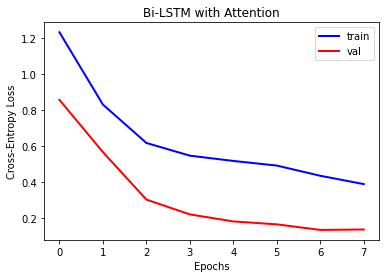

In [62]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Bi-LSTM with Attention')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

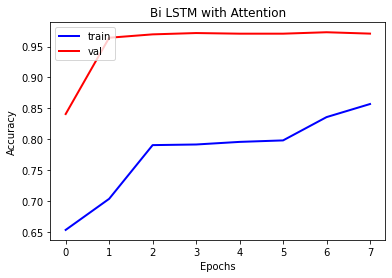

In [63]:
plt.figure()
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Bi LSTM with Attention')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()